# Keras를 활용한 Tensorflow 모델 만들기

케라시는 모든 종류의 신경망을 손쉽게 만들고 훈련, 평가, 실행할 수 잇는 고수진 딥러닝 API입니다.

쉽게 설명하자면 여러 복잡한 연산을 라이브러리내에 모두 구현을 하고 사용자가 모델의 구성만 신경 쓰게 해주는 좋은 라이브러리라고 생각하시면 됩니다.

원래는 Keras는 텐서플로우, CNTK, 시애노등을 계산 백엔드로 설정하고 사용할 수 있는데 텐서플로우가 버전 2로 업그레이드 되면서 케라스를 공식 고수준 API로 채택했고 이를 단순화하고 정리했습니다.


## 데이터 셋 준비

추후에 다음에 한번 더 다룰 것이지만 참고 사항으로 알고계시면 좋을것 같습니다.


딥러닝 라이브러리 말고 다른 ML을 위한 라이브러리인 사이킷런이 존재합니다.

사이킷런은 선형회귀 부터 시작해 clustering, svm. random forest, gradient boosting, k-means, DBSCAN등의 알고리즘에 대해 지원하는 라이브러리입니다.

이번에는 단순히 데이터셋을 받아오고 정규화 시키는데에만 사용하겠습니다.

또한 이번 데이터셋은 크기가 크지 않고 단순하기 때문에 원할한 이해를 위해 데이터로더를 사용하지 않겠습니다.

In [ ]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(dataset.data, dataset.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

데이터 셋 설명

In [ ]:
dataset.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
print("Train dataset 크기 : ", np.shape(X_train_full))
print("Test dataset 크기 :", np.shape(X_test))

Train dataset 크기 :  (15480, 8)
Test dataset 크기 : (5160, 8)


dataset.feature_names에서 볼 수 있듯이 feature마다 단위가 다릅니다. 따라서 우리는 특정 단위에 따라 값의 중요성이 부여되는 것을 원치 않기 때문에 정규화를 진행해야합니다.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # fit transform은 데이터 feature마다의 평균과 편차를 구해서 정규화를 진행하는 함수입니다.
X_valid = scaler.transform(X_valid) # transform은 위에서 구했던 평균과 편차를 그대로 가져와 데이터를 정규화 하는 것입니다.
X_test = scaler.transform(X_test)

# 1. Sequential API로 만들어보는 회귀 모델

Sequential API는 층을 순차적으로 쌓아서 모델을 만들어주는 API입니다.

In [ ]:
# 모델 만들기
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation = "relu", input_shape = X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

다음은 tensorflow로 쌓은 모델에 대한 설명을 보여주는 함수입니다.

저희가 만든 모델 객체에 .summary를 해서 호출할 수 있습니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


저희가 만든 모델에 대한 설명은 다음과 같습니다.

1. 인풋이 들어오면 이를 Unit이 30개인 레이어에 넘겨줍니다.
 - 이때 사용한 activation 함수는 relu입니다.
 - inputshape를 정의하는 방법은 2가지 정도입니다. 
    1. tf.keras.layers.Input를 통해 Input을 위한 layer를 만드는 겁니다.
    2. 두번째는 위의 예시처럼 Input 다음에 오는 첫번째 레이어에 Input shape를 지정하는 겁니다.

    사실 Input shape없어도 돌아가긴합니다만 남들이 읽기 쉽고 유지보수를 쉽게 하고 여러 실험을 진행하기 위해서는 이러한 사소한 부분을 챙겨서 가는 습관을 가지는게 좋습니다.

2. 이후 이를 마지막 레이어에 넘기게 됩니다. 위의 데이터셋은 회귀문제이기 때문에 예측해야하는 값이 가격 하나라 unit이 1개인 layer에 넘겨주게 된겁니다.

사실 위의 summary말고 더 예쁜 시각화 방법이 있습니다. 

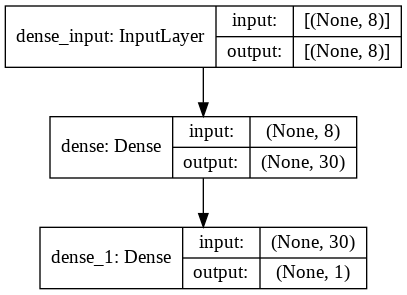

In [ ]:
tf.keras.utils.plot_model(model, "test_model.png", show_shapes = True)

## 모델 compile시키고 학습 시키기

여기서 우리가 compile이라고 이야기 하는거는 우리가 어떤 손실함수를 사용할 것이고 어떤 optimizer를 사용할 것인지를 알려주는 부분입니다.

In [ ]:
model.compile(loss = "mean_squared_error", optimizer = "Adam")

이제 우리는 학습을 진행 시킬겁니다. pytorch는 우리가 학습 프로세스를 정의해줬어야했지만 Keras는 fit함수로 처리를 해버립니다.

In [ ]:
history = model.fit(x = X_train, y = y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3921 - val_loss: 2.9345
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5306 - val_loss: 0.8708
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4251 - val_loss: 0.4144
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3906 - val_loss: 0.3988
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3748 - val_loss: 2.0616
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3678 - val_loss: 0.5648
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3633 - val_loss: 1.8853
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3598 - val_loss: 0.3628
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3549 - val_loss: 0.3570
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3544 - val_loss: 0.7819

fit함수가 반환하는 History 객체에는 훈련 파라미터, 수행된 에포크 리스트가 포함됩니다.

사실 이것 말고 우리가 해당 객체를 쓰는 주요한 이유는 에포크가 끝날때마다 훈련세트와 검증 세트에 대한 손실과 측정한 지표를 담은 딕셔너리를 객체에 저장해준다는 겁니다.

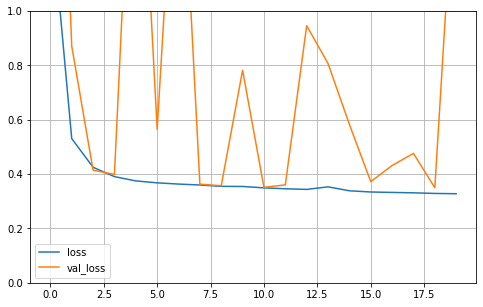

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt # 이 부분은 나중에 시각화 관련해서 따로 자료를 만들겠습니다.

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 모델 평가하기

Keras는 fancy한 기능을 하나 더 제공하는데요. evaluate입니다. 우리가 굳이 test를 위한 코드를 따로 만들 필요가 없습니다.

In [ ]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 920us/step - loss: 0.5450


# Quiz 1


다음과 같은 모델을 만들어 보고 Parameter 갯수가 왜 저렇게 되는지 설명해보세요.

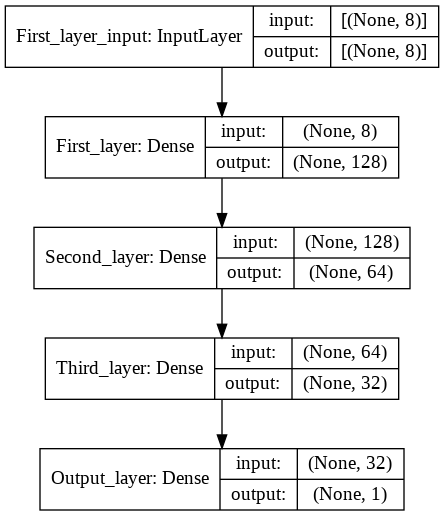

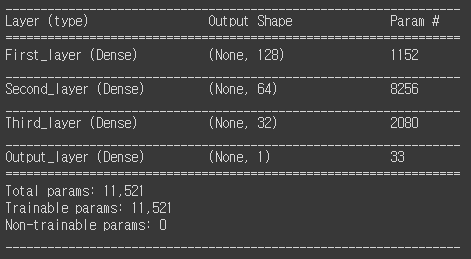

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation = "relu", input_shape = X_train.shape[1:], name = "First_layer"),
#     tf.keras.layers.Dense(64, activation = "sigmoid", name = "Second_layer"),
#     tf.keras.layers.Dense(32, activation = "relu", name ="Third_layer"),
#     tf.keras.layers.Dense(1, name = "Output_layer")
# ])

# 함수형 API를 사용해 복잡한 모델 만들기

만약 우리가 다음과 같은 모델을 만들고자 할때 Sequential로는 만들지 못합니다. 이런 경우이 좀 더 유연하게 모델을 만들기 위해서 사용하는게 함수형 API입니다.

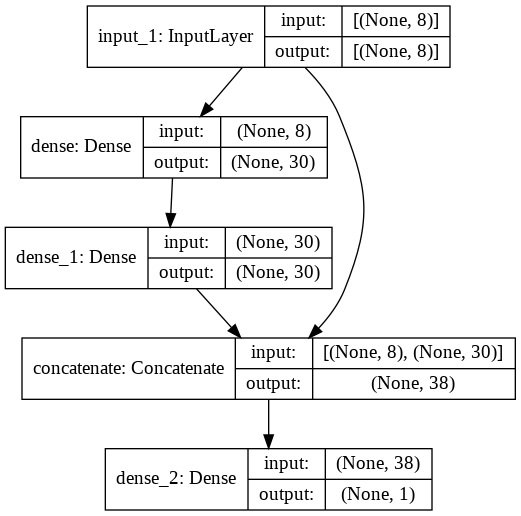

In [ ]:
def build_model():
    input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
    print(input_)
    hidden1 = tf.keras.layers.Dense(30, activation="relu")(input_)
    print(hidden1)
    hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
    concat = tf.keras.layers.concatenate([input_, hidden2])
    output = tf.keras.layers.Dense(1)(concat)
    model = tf.keras.models.Model(inputs=[input_], outputs=[output])
    return model

이건 개인 코딩 취향인거 같은데 저는 개인적으로 함수형 API를 사용할때는 저렇게 build model을 해서 model을 반환 시키는 함수를 사용해서 주로 사용합니다.

위의 함수에서 가장 특이한 부분은 아마 concatenate 부분일겁니다. 먼저 concatentate는 두개의 레이어를 합쳐준다고 생각하시면 될것 같습니다. 다만 어떤 axis를 기준으로 합칠 것인가에 대해 궁금할것입니다.

이를 위해서는 함수의 default 입력변수를 살펴볼 필요가 있습니다.

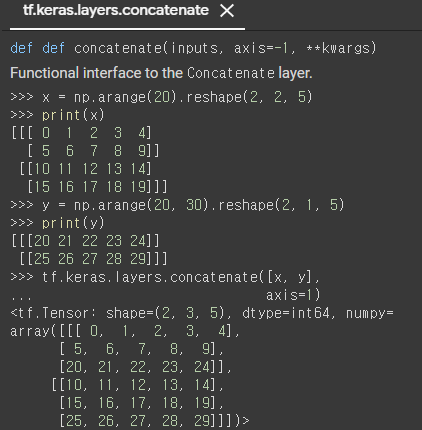

기본적인 함수 정의에서도 볼 수 있듯이 가장 마지막 axis를 기준으로 concatenate를 시켜줍니다.

## 딥러닝 모델에서 차원의 저주

이건 제가 명명한건데요. 차원의 저주는 원래 차원이 높아짐에 따라 여러 이유때문에 모델의 성능이 떨어지는 것을 의미하지만 제가 느끼는 차원의 저주는 딥러닝 모델을 customize할 때 옵니다.

텐서를 사실 이제까지는 한번 넣고 모델이 output을 뱉으면 끝이지만 추후에는 해당 텐서에 여러 다른 과정을 거치게 합니다. 그리고 다시 모델에 넣는 경우도 있죠. 이렇게 되는 과정에서 레이어들의 차원등을 무시하고 reduce_sum이나 행렬 곱을 진행하면서 어떻게 모양이 바뀌는지 생각을 안하면서 코딩을 하고 나면 디버깅 하는데 정말 많은 시간이 소요됩니다.(저는 이거 생각 안하고 코딩하다가 3일을 날려먹은적이 있습니다.) 그렇기 때문에 위의 concatenate 처럼 사실 생각해보면 아무것도 아닌 함수이지만 axis등을 한번 짚고 넘어가는 습관을 가지시면 저처럼 3일 버리는 코딩 같은거는 안 하실 수 있습니다.